# Лабораторная работа 2.
**выполнила: Козлова Светлана (группа 312)**

In [1]:
test_file_path = '/kaggle/input/mai-ml-lab-2-fiit-2025/test_c.csv'
train_file_path = '/kaggle/input/mai-ml-lab-2-fiit-2025/train_c.csv'
ex_file_path = '/kaggle/input/mai-ml-lab-2-fiit-2025/ex_c.csv'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from sklearn.metrics import precision_recall_curve, average_precision_score

In [3]:
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

**Задание 1**

Разведочный анализ данных (EDA). Построение графиков зависимости некоторых признаков друг от друга. Построение графика целевой переменной. Построение матрицы корреляции. Выводы. Подготовка данных для обучения на основе выводов.

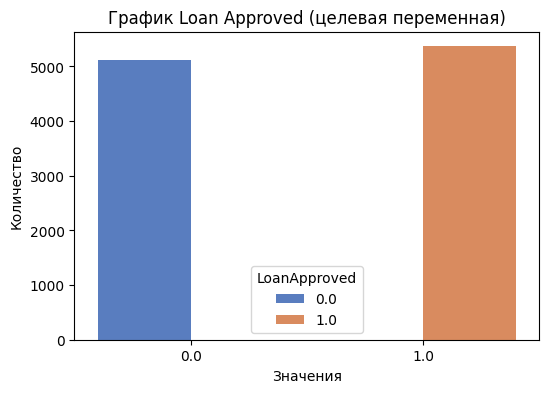

In [4]:
# целевая переменная
plt.figure(figsize=(6, 4))
sns.countplot(x='LoanApproved', data=train_data, palette='muted', hue='LoanApproved')
plt.title('График Loan Approved (целевая переменная)')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.show()

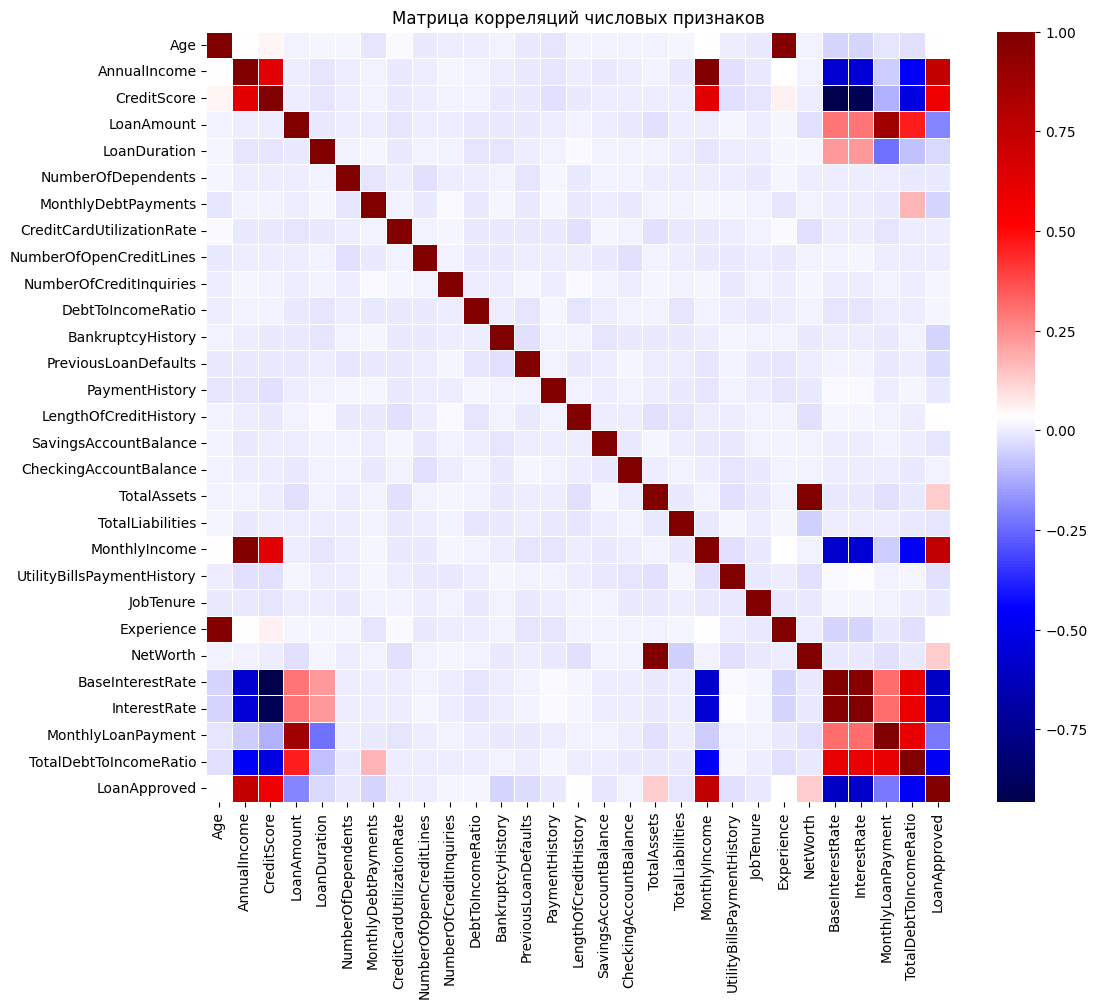

In [5]:
plt.figure(figsize=(12, 10))
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
corr_matrix = train_data[numeric_columns].corr()
sns.heatmap(corr_matrix, annot=False, cmap='seismic', linewidths=0.5)
plt.title('Матрица корреляций числовых признаков')
plt.show()

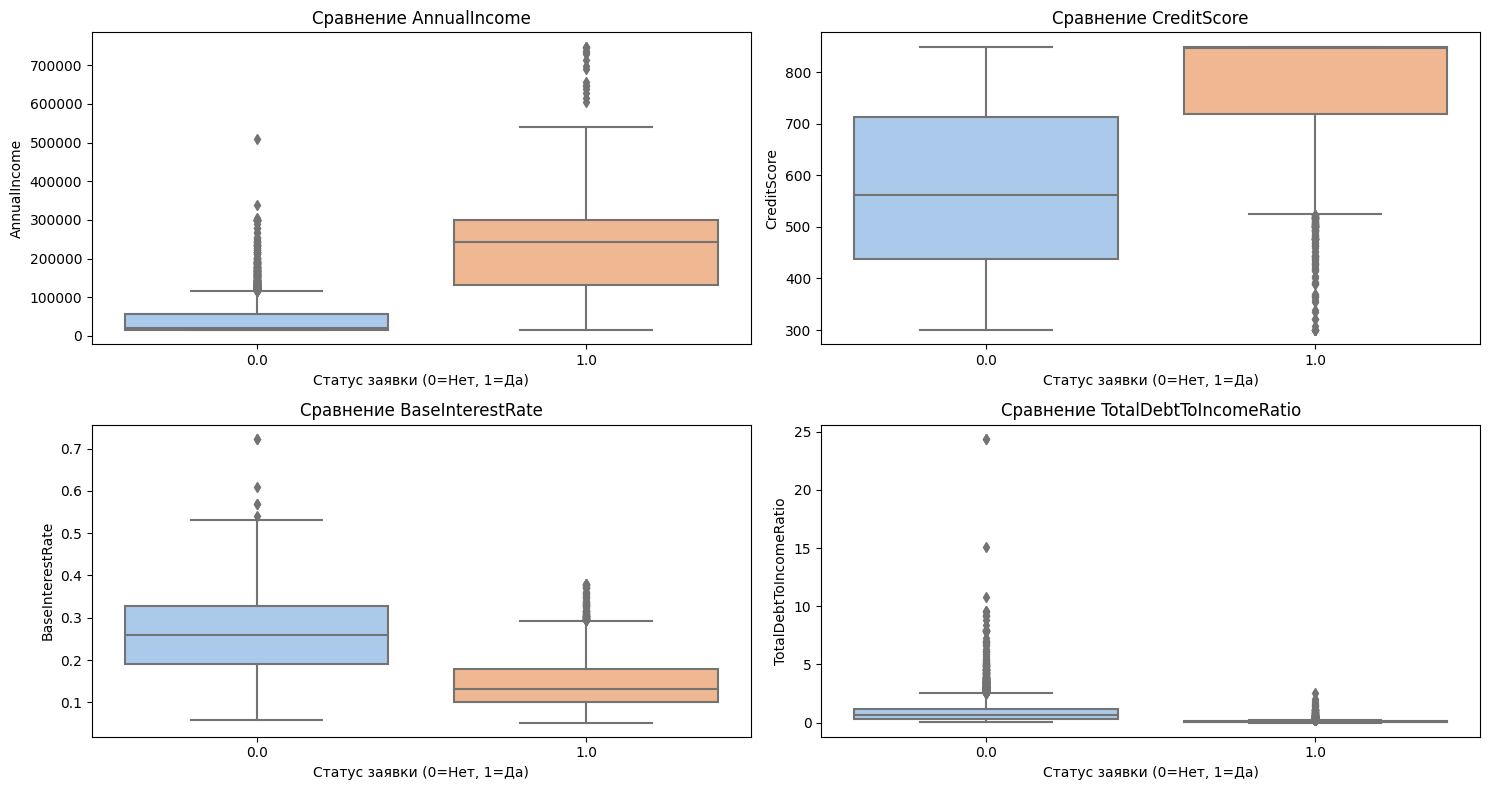

In [6]:
# взяли признаки, которые (по матрице корреляций) влияют больше всего
# "ящики с усами" - если медианы признаков далеко друг от друга, то признак важен
features = ['AnnualIncome', 'CreditScore', 'BaseInterestRate', 'TotalDebtToIncomeRatio']

plt.figure(figsize=(15, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=train_data, x='LoanApproved', y=feature, palette='pastel')
    plt.title(f'Сравнение {feature}')
    plt.xlabel('Статус заявки (0=Нет, 1=Да)')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

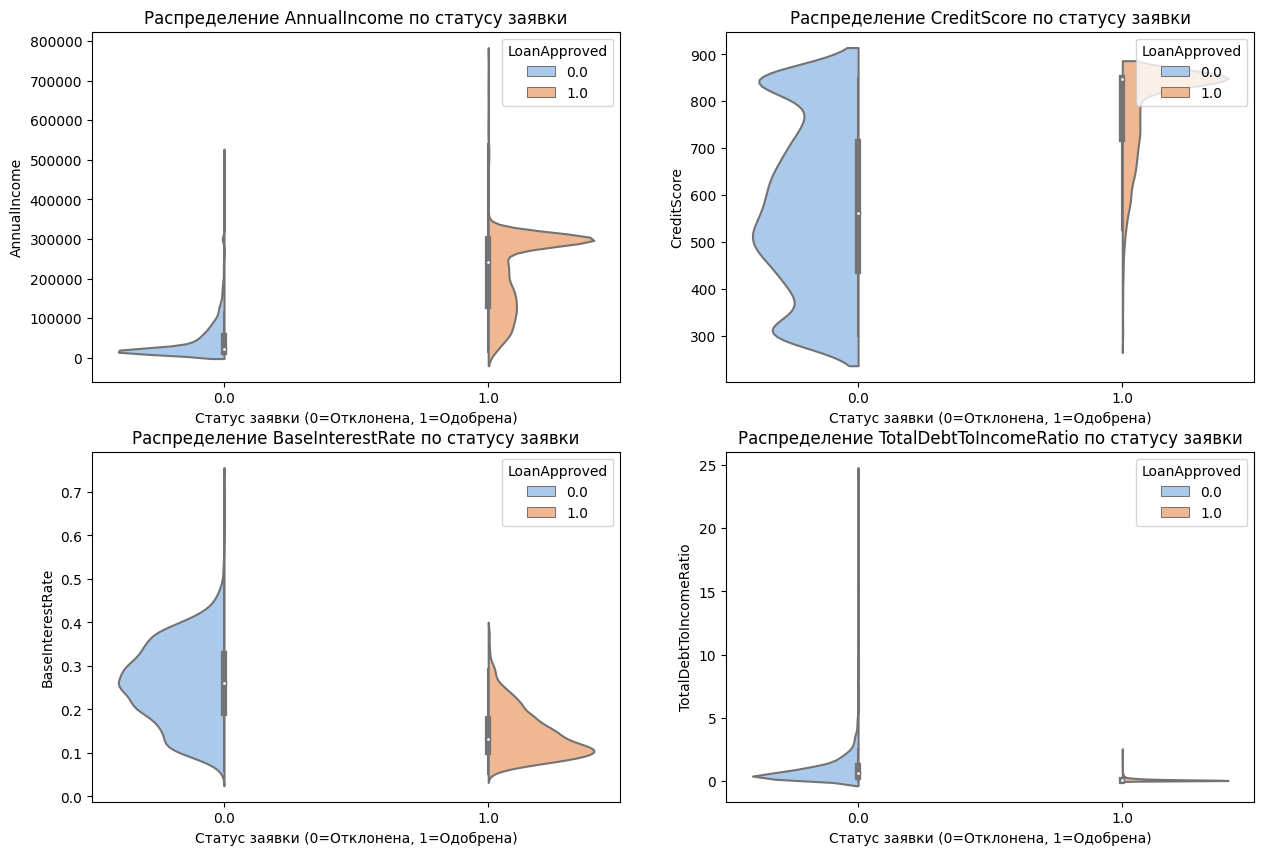

In [7]:
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.violinplot(data=train_data, x='LoanApproved', y=feature, palette="pastel", split=True, hue='LoanApproved')
    plt.title(f'Распределение {feature} по статусу заявки')
    plt.xlabel('Статус заявки (0=Отклонена, 1=Одобрена)')
    
plt.show()

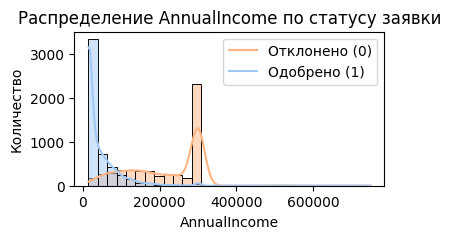

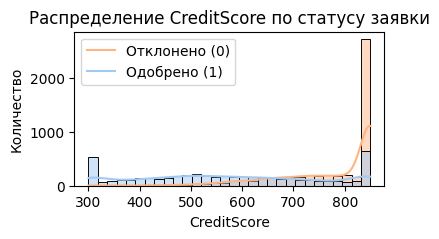

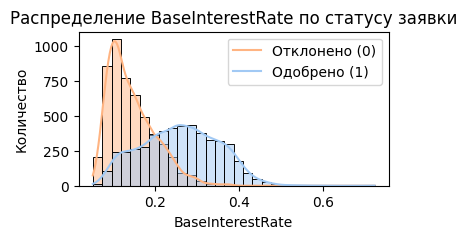

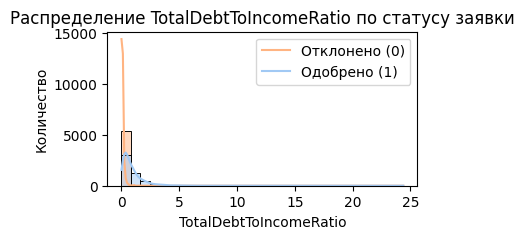

In [8]:
for feature in features:
    plt.figure(figsize=(4, 2))
    sns.histplot(data=train_data, x=feature, hue='LoanApproved', bins=30, kde=True, palette='pastel')
    plt.title(f'Распределение {feature} по статусу заявки')
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.legend(['Отклонено (0)', 'Одобрено (1)'])
    plt.show()

In [9]:
target = 'LoanApproved'

X = train_data.drop(columns=[target])
y = train_data[target]

In [10]:
notna_mask = y.notna()
X = X[notna_mask]
y = y[notna_mask]

In [11]:
X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded = X_encoded.fillna(X_encoded.median())

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

In [13]:
X_test_encoded = pd.get_dummies(test_data, drop_first=True)
X_test_encoded = X_test_encoded.reindex(columns=X_encoded.columns, fill_value=0)

In [14]:
X_test_encoded = X_test_encoded.fillna(X_test_encoded.median())
X_test_scaled = scaler.transform(X_test_encoded)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

y_train = y_train.values
y_val = y_val.values

**Задание 6 (реализовано заранее, чтобы использовать при тестировании)**

Реализовать метрику Accuracy, протестировать и сравнить полученный результат с Accuracy из sklearn.

In [16]:
def custom_accuracy(real, prediction):
    correct_number = np.sum(real == prediction)
    return correct_number / len(real)

In [17]:
from sklearn.metrics import accuracy_score

test_values_real = np.array([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1])
test_values_prediction = np.array([1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0])
print(f'custom accuracy:  {custom_accuracy(test_values_real, test_values_prediction)}')
print(f'sklearn accuracy: {accuracy_score(test_values_real, test_values_prediction)}')

custom accuracy:  0.5333333333333333
sklearn accuracy: 0.5333333333333333


**Задание 7 (реализовано заранее, чтобы использовать при тестировании)**

Реализовать Precision, протестировать и сравнить с метрикой из sklearn.

In [18]:
def custom_precision(real, prediction):
    tp = np.sum((real == 1) & (prediction == 1))
    fp = np.sum((real == 0) & (prediction == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

In [19]:
from sklearn.metrics import precision_score

print(f'custom precision:  {custom_precision(test_values_real, test_values_prediction)}')
print(f'sklearn precision: {precision_score(test_values_real, test_values_prediction)}')

custom precision:  0.7
sklearn precision: 0.7


**Задание 8 (реализовано заранее, чтобы использовать при тестировании)**

Реализовать Recall, протестировать и сравнить с метрикой из sklearn.

In [20]:
def custom_recall(real, prediction):
    tp = np.sum((real == 1) & (prediction == 1))
    fn = np.sum((real == 1) & (prediction == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

In [21]:
from sklearn.metrics import recall_score

print(f'custom recall:  {custom_recall(test_values_real, test_values_prediction)}')
print(f'sklearn recall: {recall_score(test_values_real, test_values_prediction)}')

custom recall:  0.6363636363636364
sklearn recall: 0.6363636363636364


**Задание 9 (реализовано заранее, чтобы использовать при тестировании)**

Реализовать F1-score, протестировать и сравнить с метрикой из sklearn.

In [22]:
def custom_f1_score(real, prediction):
        p = custom_precision(real, prediction)
        r = custom_recall(real, prediction)
        return 2 * (p * r) / (p + r) if (p + r) > 0 else 0

In [23]:
from sklearn.metrics import f1_score

print(f'custom f1-score:  {custom_f1_score(test_values_real, test_values_prediction)}')
print(f'sklearn f1-score: {f1_score(test_values_real, test_values_prediction)}')

custom f1-score:  0.6666666666666666
sklearn f1-score: 0.6666666666666666


**Дополнительное задание**

Реализация метрик AUC-ROC, AUC-PR и сравнение с готовыми реализациями.

In [24]:
def custom_auc_roc(real, probabilities):
    desc_indices = np.argsort(probabilities)[::-1]
    prob_sorted = probabilities[desc_indices]
    real_sorted = real[desc_indices]
    
    distinct_value_indices = np.where(np.diff(prob_sorted) != 0)[0]
    
    threshold_indices = np.r_[distinct_value_indices, len(real_sorted) - 1]
    
    tps = np.cumsum(real_sorted)
    fps = np.cumsum(1 - real_sorted)
    
    tpr = np.r_[0, tps[threshold_indices] / tps[-1] if tps[-1] > 0 else np.zeros_like(tps[threshold_indices])]
    fpr = np.r_[0, fps[threshold_indices] / fps[-1] if fps[-1] > 0 else np.zeros_like(fps[threshold_indices])]
    
    return np.trapz(tpr, fpr)

In [25]:
from sklearn.metrics import roc_auc_score

test_values_probs = np.array([0.9, 0.8, 0.7, 0.95, 0.3, 0.5, 0.2,
                              0.91, 0.93, 0.99, 0.45, 0.56, 0.4, 0.7, 0.8])

print(f'custom AUC-ROC:  {custom_auc_roc(test_values_real, test_values_probs)}')
print(f'sklearn AUC-ROC: {roc_auc_score(test_values_real, test_values_probs)}')

custom AUC-ROC:  0.8068181818181819
sklearn AUC-ROC: 0.8068181818181819


In [26]:
def custom_auc_pr(real, probabilities):
    real = np.asarray(real, dtype=np.float64)
    probabilities = np.asarray(probabilities, dtype=np.float64)
    
    n_positive = np.sum(real)
    if n_positive == 0:
        return 0.0
    
    desc_score_indices = np.argsort(probabilities, kind='mergesort')[::-1]
    prob_sorted = probabilities[desc_score_indices]
    real_sorted = real[desc_score_indices]
    
    distinct_value_indices = np.where(np.diff(prob_sorted) != 0)[0]
    threshold_idxs = np.r_[-1, distinct_value_indices]
    
    tp = np.cumsum(real_sorted)
    fp = np.cumsum(1 - real_sorted)
    
    tp_at_thresholds = tp[threshold_idxs]
    fp_at_thresholds = fp[threshold_idxs]
    
    precision_at_thresholds = np.divide(
        tp_at_thresholds,
        tp_at_thresholds + fp_at_thresholds,
        out=np.ones_like(tp_at_thresholds, dtype=float),
        where=(tp_at_thresholds + fp_at_thresholds) != 0
    )
    recall_at_thresholds = tp_at_thresholds / n_positive
    
    precision = np.r_[1.0, precision_at_thresholds]
    recall = np.r_[0.0, recall_at_thresholds]
    
    return np.trapz(precision, recall)

In [27]:
print(f'custom AUC-PR:  {custom_auc_pr(test_values_real, test_values_probs)}')
print(f'sklearn AUC-PR: {average_precision_score(test_values_real, test_values_probs)}')

custom AUC-PR:  0.9105329014419924
sklearn AUC-PR: 0.921144512053603


**Задание 2**

Реализовать класс бэггинга, который для обучения методом fit обучает n базовых моделей b. Сравнить полученные после обучения результаты с реализацией из sklearn.

In [28]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier

class SimpleBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=10, random_state=42):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def fit(self, X, y):
        self.models = list()
        rng_generator = np.random.default_rng(self.random_state)
        number_samples = X.shape[0]

        for i in range(self.n_estimators):
            indices = rng_generator.choice(number_samples, size=number_samples, replace=True)
            X_sample, y_sample = X[indices], y[indices]
            
            if self.base_estimator is None:
                model = DecisionTreeClassifier(max_depth=10, random_state=self.random_state + i)
            else:
                model = clone(self.base_estimator)

            model.fit(X_sample, y_sample)
            self.models.append(model)
        return self

    
    def predict_proba(self, X):
        probas_array = np.array([model.predict_proba(X)[:, 1] for model in self.models])
        mean_proba = np.mean(probas_array, axis=0)
        return np.vstack([1 - mean_proba, mean_proba]).T

    
    def predict(self, X):
        probabilities = self.predict_proba(X)[:, 1]
        return (probabilities > 0.5).astype(int)

In [29]:
from sklearn.ensemble import RandomForestClassifier

print('Сравнение моей реализации с реализацией из sklearn')

print('Обучение (моя реализация)...')
my_classifier = SimpleBaggingClassifier(n_estimators=20, random_state=42)
my_classifier.fit(X_train, y_train)
print('Предсказание (моя реализация)...')
my_prediction = my_classifier.predict_proba(X_val)[:, 1]
my_binary_prediction = (my_prediction >= 0.5).astype(int)
print('Работа с моей реализацией завершена.')

print('Обучение (реализация из sklearn)...')
sk_classifier = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=42)
sk_classifier.fit(X_train, y_train)
print('Предсказание (реализация из sklearn)...')
sk_prediction = sk_classifier.predict_proba(X_val)[:, 1]
sk_binary_prediction = (sk_prediction >= 0.5).astype(int)
print('Обучение методом из sklearn завершено.')

print('Результаты')
my_auc = custom_auc_roc(y_val, my_prediction)
sk_auc = custom_auc_roc(y_val, sk_prediction)
print(f'ROC-AUC (моя реализация):        {my_auc:.10f}')
print(f'ROC-AUC (реализация из sklearn): {sk_auc:.10f}')
print()
my_pr = custom_auc_pr(y_val, my_prediction)
sk_pr = custom_auc_pr(y_val, sk_prediction)
print(f'AUC-PR (моя реализация): {my_pr:.10f}')
print(f'AUC-PR (реализация из sklearn): {sk_pr:.10f}')
print()
my_accuracy = custom_accuracy(y_val, my_binary_prediction)
sk_accuracy = custom_accuracy(y_val, sk_binary_prediction)
print(f'Accuracy (моя реализация):        {my_accuracy:.10f}')
print(f'Accuracy (реализация из sklearn): {sk_accuracy:.10f}')
print()
my_precision = custom_precision(y_val, my_binary_prediction)
sk_precision = custom_precision(y_val, sk_binary_prediction)
print(f'Precision (моя реализация):        {my_precision:.10f}')
print(f'Precision (реализация из sklearn): {sk_precision:.10f}')
print()
my_recall = custom_recall(y_val, my_binary_prediction)
sk_recall = custom_recall(y_val, sk_binary_prediction)
print(f'Recall (моя реализация):        {my_recall:.10f}')
print(f'Recall (реализация из sklearn): {sk_recall:.10f}')
print()
my_f1_score = custom_f1_score(y_val, my_binary_prediction)
sk_f1_score = custom_f1_score(y_val, sk_binary_prediction)
print(f'f1-score (моя реализация):        {my_f1_score:.10f}')
print(f'f1-score (реализация из sklearn): {sk_f1_score:.10f}')

Сравнение моей реализации с реализацией из sklearn
Обучение (моя реализация)...
Предсказание (моя реализация)...
Работа с моей реализацией завершена.
Обучение (реализация из sklearn)...
Предсказание (реализация из sklearn)...
Обучение методом из sklearn завершено.
Результаты
ROC-AUC (моя реализация):        0.9760319374
ROC-AUC (реализация из sklearn): 0.9445155195

AUC-PR (моя реализация): 0.9780649631
AUC-PR (реализация из sklearn): 0.9440235358

Accuracy (моя реализация):        0.9213536702
Accuracy (реализация из sklearn): 0.8722592946

Precision (моя реализация):        0.9196675900
Precision (реализация из sklearn): 0.8752327747

Recall (моя реализация):        0.9273743017
Recall (реализация из sklearn): 0.8752327747

f1-score (моя реализация):        0.9235048679
f1-score (реализация из sklearn): 0.8752327747


Получаем хорошие значения ROC-AUC, AUC-PR, accuracy, precision, recall, f1_score (близкие к 1).

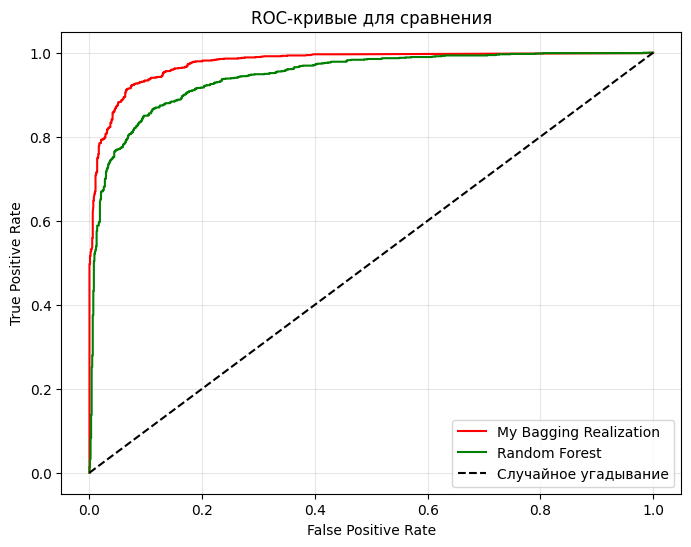

In [30]:
from sklearn.metrics import roc_curve

fpr_bag, tpr_bag, _ = roc_curve(y_val, my_prediction)
fpr_sklearn, tpr_sklearn, _ = roc_curve(y_val, sk_prediction)

plt.figure(figsize=(8, 6))
plt.plot(fpr_bag, tpr_bag, label=f'My Bagging Realization', color='red')
plt.plot(fpr_sklearn, tpr_sklearn, label=f'Random Forest', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для сравнения')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Задание 3**

Реализовать класс градиентного бустинга, который для обучения методом fit обучает n базовых моделей b. Сравнить полученные после обучения результаты с реализацией из sklearn и других библиотек.

In [31]:
from sklearn.tree import DecisionTreeRegressor


def sigmoid(z):
        return 1 / (1 + np.exp(-z))


class SimpleGradientBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.models = []
        self.init_pred = 0.0

    
    def fit(self, X, y):
        self.models = list()

        positive_rate = np.mean(y)
        positive_rate = np.clip(positive_rate, 1e-10, 1-1e-10)
        
        self.init_pred = np.log(positive_rate / (1 - positive_rate))

        current_prediction = np.full(y.shape, self.init_pred)

        for i in range(self.n_estimators):
            pred = sigmoid(current_prediction)
            pseudo_residuals = y - pred

            current_model = DecisionTreeRegressor(max_depth=self.max_depth,
                                                  random_state=self.random_state + i)
            current_model.fit(X, pseudo_residuals)
            self.models.append(current_model)
            
            current_prediction += self.learning_rate * current_model.predict(X)
            
        return self

    
    def predict_proba(self, X):
        new_prediction = np.full(X.shape[0], self.init_pred)
        
        for current_model in self.models:
            new_prediction += self.learning_rate * current_model.predict(X)

        probabilities = sigmoid(new_prediction)
        return np.column_stack([1 - probabilities, probabilities])

    
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

In [32]:
print('Сравнение моей реализации GradientBoostingClassifier с реализацией из sklearn')

print('Обучение (моя реализация)...')
my_gb_classifier = SimpleGradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
my_gb_classifier.fit(X_train, y_train)

print('Предсказание (моя реализация)...')
my_gb_prediction = my_gb_classifier.predict_proba(X_val)[:, 1]

print('Работа с моей реализацией завершена.')

Сравнение моей реализации GradientBoostingClassifier с реализацией из sklearn
Обучение (моя реализация)...
Предсказание (моя реализация)...
Работа с моей реализацией завершена.


In [33]:
from sklearn.ensemble import GradientBoostingClassifier

print('Обучение (реализация из sklearn)...')
sk_gb_classifier = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
sk_gb_classifier.fit(X_train, y_train)

print('Предсказание (реализация из sklearn)...')
sk_gb_prediction = sk_gb_classifier.predict_proba(X_val)[:, 1]

print('Работа с реализацией из sklearn завершена.')

Обучение (реализация из sklearn)...
Предсказание (реализация из sklearn)...
Работа с реализацией из sklearn завершена.


In [34]:
print(f'ROC-AUC при моей реализации:      {custom_auc_roc(y_val, my_gb_prediction):.5f}')
print(f'ROC-AUC с реализацией из sklearn: {custom_auc_roc(y_val, sk_gb_prediction):.5f}')
print()

my_binary_gb_prediction = (my_gb_prediction >= 0.5).astype(int)
sk_binary_gb_prediction = (sk_gb_prediction >= 0.5).astype(int)

my_gb_pr = custom_auc_pr(y_val, my_gb_prediction)
sk_gb_pr = custom_auc_pr(y_val, sk_gb_prediction)
print(f'AUC-PR (моя реализация): {my_gb_pr:.10f}')
print(f'AUC-PR (реализация из sklearn): {sk_gb_pr:.10f}')
print()
my_gb_accuracy = custom_accuracy(y_val, my_binary_gb_prediction)
sk_gb_accuracy = custom_accuracy(y_val, sk_binary_gb_prediction)
print(f'Accuracy (моя реализация):        {my_gb_accuracy:.10f}')
print(f'Accuracy (реализация из sklearn): {sk_gb_accuracy:.10f}')
print()
my_gb_precision = custom_precision(y_val, my_binary_gb_prediction)
sk_gb_precision = custom_precision(y_val, sk_binary_gb_prediction)
print(f'Precision (моя реализация):        {my_gb_precision:.10f}')
print(f'Precision (реализация из sklearn): {sk_gb_precision:.10f}')
print()
my_gb_recall = custom_recall(y_val, my_binary_gb_prediction)
sk_gb_recall = custom_recall(y_val, sk_binary_gb_prediction)
print(f'Recall (моя реализация):        {my_gb_recall:.10f}')
print(f'Recall (реализация из sklearn): {sk_gb_recall:.10f}')
print()
my_gb_f1_score = custom_f1_score(y_val, my_binary_gb_prediction)
sk_gb_f1_score = custom_f1_score(y_val, sk_binary_gb_prediction)
print(f'f1-score (моя реализация):        {my_gb_f1_score:.10f}')
print(f'f1-score (реализация из sklearn): {sk_gb_f1_score:.10f}')

ROC-AUC при моей реализации:      0.97284
ROC-AUC с реализацией из sklearn: 0.97919

AUC-PR (моя реализация): 0.8797935419
AUC-PR (реализация из sklearn): 0.9807029579

Accuracy (моя реализация):        0.9108674929
Accuracy (реализация из sklearn): 0.9223069590

Precision (моя реализация):        0.9057639524
Precision (реализация из sklearn): 0.9229340761

Recall (моя реализация):        0.9217877095
Recall (реализация из sklearn): 0.9255121043

f1-score (моя реализация):        0.9137055838
f1-score (реализация из sklearn): 0.9242212924


Получены хорошие значения метрик (близки к 1). Можем сделать вывод о том, что наша реализация не сильно хуже, чем реализация из sklearn (по крайней мере на данном датасете, при обучении на тренировочной выборке и валидации на валидационной выборке). Поэтому дальнейшую работу будем проводить непосредственно с нашей метрикой - AUC-ROC.

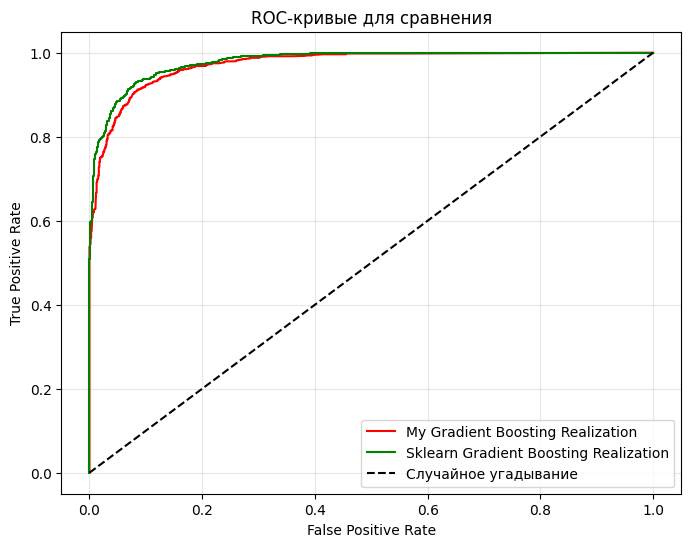

In [35]:
fpr_mygb, tpr_mygb, _ = roc_curve(y_val, my_gb_prediction)
fpr_sklearn_gb, tpr_sklearn_gb, _ = roc_curve(y_val, sk_gb_prediction)

plt.figure(figsize=(8, 6))
plt.plot(fpr_mygb, tpr_mygb, label=f'My Gradient Boosting Realization', color='red')
plt.plot(fpr_sklearn_gb, tpr_sklearn_gb, label=f'Sklearn Gradient Boosting Realization', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для сравнения')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Задание 4**

Сравнить результаты работы алгоритмов градиентного бустинга: реализация из sklearn, LightGBM, XGBoost, CatBoost. Выбрать алгоритм с лучшей метрикой на данных.

In [36]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

compared_models = {
    'SimpleGradientBoostingClassifier': SimpleGradientBoostingClassifier(random_state=42),
    'SklearnGradientBoosting': GradientBoostingClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'CatBoost': cb.CatBoostClassifier(verbose=0, random_state=42, allow_writing_files=False)
}

comparing_result = dict()

SimpleGradientBoostingClassifier ROC-AUC = 0.9728385599
SklearnGradientBoosting ROC-AUC = 0.9803323586
LightGBM             ROC-AUC = 0.9812143564
XGBoost              ROC-AUC = 0.9822145601
CatBoost             ROC-AUC = 0.9812061729


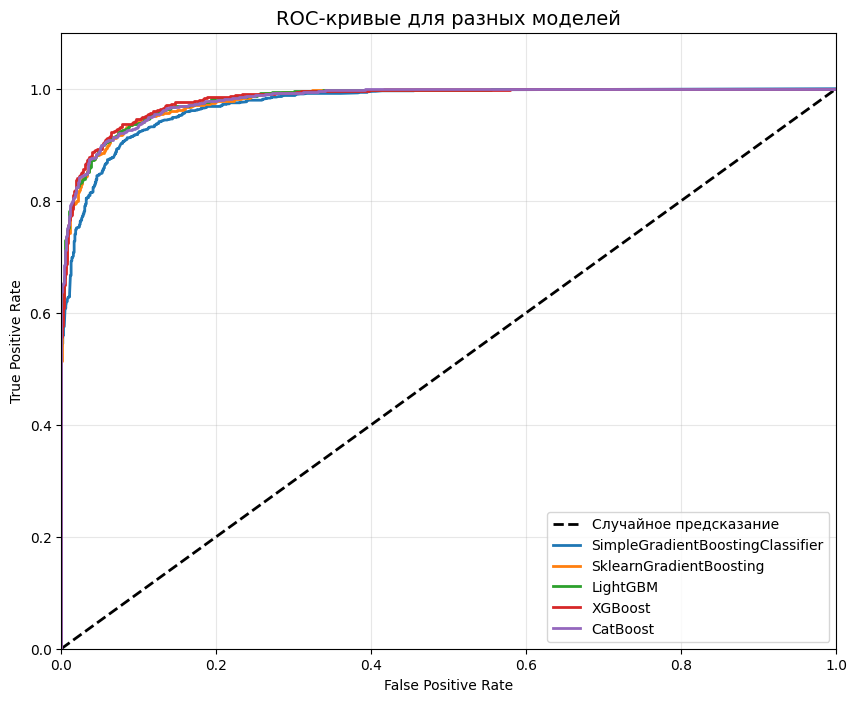

In [37]:
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Случайное предсказание')

for name, model in compared_models.items():
    model.fit(X_train, y_train)
    prediction = model.predict_proba(X_val)[:, 1]
    score = custom_auc_roc(y_val, prediction)
    
    comparing_result[name] = score
    fpr, tpr, _ = roc_curve(y_val, prediction)
    
    plt.plot(fpr, tpr, lw=2, label=f'{name}')
    
    print(f"{name:20} ROC-AUC = {score:.10f}")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.10])

plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)

plt.title('ROC-кривые для разных моделей', fontsize=14)
plt.legend(loc="lower right", fontsize=10)

plt.grid(True, alpha=0.3)
plt.show()

In [38]:
choosed_best_model_name = max(comparing_result, key=comparing_result.get)
print()
print(f'Лучшая модель: {choosed_best_model_name} (по AUC-ROC)')


Лучшая модель: XGBoost (по AUC-ROC)


**Задание 5**

Подобрать оптимальные гиперпараметры для лучшей модели с помощью Optuna.

In [39]:
import optuna

def catboost_hyperparameter_tuning(trial):
    params = {
            'iterations': trial.suggest_int('iterations', 100, 800),
            'depth': trial.suggest_int('depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'verbose': 0,
            'random_state': 42,
            'allow_writing_files': False
        }
    return cb.CatBoostClassifier(**params)


def xgboost_hyperparameter_tuning(trial):
    params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 800),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'use_label_encoder': False,
            'eval_metric': 'logloss',
            'random_state': 42
        }
    return xgb.XGBClassifier(**params)


def lightgbm_hyperparameter_tuning(trial):
    params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 800),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'verbose': -1,
            'random_state': 42
        }
    return lgb.LGBMClassifier(**params)


def sklearn_gb_hyperparameter_tuning(trial):
    params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'random_state': 42
        }
    return GradientBoostingClassifier(**params)


def custom_gb_hyperparameter_tuning(trial):
    params = {
            'n_estimators': trial.suggest_int('n_estimators', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 2, 6),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3),
            'random_state': 42
        }
    return SimpleGradientBoostingClassifier(**params)


def optimize_for_hyperparameter_tuning(trial, model_name):
    if model_name == 'CatBoost':
        model = catboost_hyperparameter_tuning(trial)
    elif model_name == 'XGBoost':
        model = xgboost_hyperparameter_tuning(trial)
    elif model_name == 'LightGBM':
        model = lightgbm_hyperparameter_tuning(trial)
    elif model_name == 'SklearnGradientBoosting':
        model = sklearn_gb_hyperparameter_tuning(trial)
    elif model_name == 'SimpleGradientBoostingClassifier':
        model = custom_gb_hyperparameter_tuning(trial)
    model.fit(X_train, y_train)
    prediction = model.predict_proba(X_val)[:, 1]
    return custom_auc_roc(y_val, prediction)
    
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: optimize_for_hyperparameter_tuning(trial, choosed_best_model_name), n_trials=15)

print()
print(f'Лучшая модель: {choosed_best_model_name}')
print()
print(f'Лучшие параметры для нее: {study.best_params}')
print()
print(f'Лучший ROC-AUC: {study.best_value}')

[I 2025-12-13 12:15:09,810] A new study created in memory with name: no-name-3f1c46d3-22c2-4ef5-889b-d743d43955b7
[I 2025-12-13 12:16:09,536] Trial 0 finished with value: 0.9817690147811918 and parameters: {'n_estimators': 529, 'max_depth': 4, 'learning_rate': 0.02113552724841565, 'subsample': 0.7492455798595344, 'colsample_bytree': 0.9231689497383009}. Best is trial 0 with value: 0.9817690147811918.
[I 2025-12-13 12:17:39,354] Trial 1 finished with value: 0.9820136100442273 and parameters: {'n_estimators': 727, 'max_depth': 5, 'learning_rate': 0.016198345348192755, 'subsample': 0.9805738839612359, 'colsample_bytree': 0.6089115258908746}. Best is trial 1 with value: 0.9820136100442273.
[I 2025-12-13 12:18:45,257] Trial 2 finished with value: 0.982452790386406 and parameters: {'n_estimators': 452, 'max_depth': 6, 'learning_rate': 0.03032719113023906, 'subsample': 0.7071633433893124, 'colsample_bytree': 0.8196066045520146}. Best is trial 2 with value: 0.982452790386406.
[I 2025-12-13 12:


Лучшая модель: XGBoost

Лучшие параметры для нее: {'n_estimators': 786, 'max_depth': 9, 'learning_rate': 0.07315913126102877, 'subsample': 0.5014983252298111, 'colsample_bytree': 0.7301531516239832}

Лучший ROC-AUC: 0.9833902540153632


**Выбор наилучшего, загрузка результатов**

In [40]:
best_params = study.best_params

base_params = {
    'random_state': 42
}

model_configs = {
    'CatBoost': {
        'class': cb.CatBoostClassifier,
        'fixed_params': {'verbose': 0, 'allow_writing_files': False}
    },
    'XGBoost': {
        'class': xgb.XGBClassifier,
        'fixed_params': {'use_label_encoder': False, 'eval_metric': 'logloss'}
    },
    'LightGBM': {
        'class': lgb.LGBMClassifier,
        'fixed_params': {'verbose': -1}
    },
    'SklearnGradientBoosting': {
        'class': GradientBoostingClassifier,
        'fixed_params': {}
    },
    'SimpleGradientBoostingClassifier': {
        'class': SimpleGradientBoostingClassifier,
        'fixed_params': {}
    }
}

if choosed_best_model_name not in model_configs:
    raise ValueError(f"Модель '{choosed_best_model_name}' не поддерживается")

config = model_configs[choosed_best_model_name]
all_params = {**best_params, **base_params, **config['fixed_params']}
final_model = config['class'](**all_params)

X_all = np.vstack([X_train, X_val])
y_all = np.concatenate([y_train, y_val])

final_model.fit(X_all, y_all)
test_probs = final_model.predict_proba(X_test_scaled)[:, 1]

submission = pd.DataFrame({
    'ID': test_data['ID'],
    'LoanApproved': test_probs
})

submission.to_csv('best_model_submission.csv', index=False)
print(submission.head(10))

   ID  LoanApproved
0   0      0.999940
1   1      0.000223
2   2      0.999994
3   3      0.999969
4   4      0.999808
5   5      0.000103
6   6      0.999998
7   7      0.999908
8   8      0.906296
9   9      0.000012


In [41]:
def objective_custom_tuning(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 30, 80),
        'max_depth': trial.suggest_int('max_depth', 2, 4),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3),
        'random_state': 42
    }
    model = SimpleGradientBoostingClassifier(**params)
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_val)[:, 1]
    return custom_auc_roc(y_val, predictions)


my_study = optuna.create_study(direction='maximize')
my_study.optimize(objective_custom_tuning, n_trials=10)
my_result_model = SimpleGradientBoostingClassifier(**my_study.best_params)

X_all = np.vstack([X_train, X_val])
y_all = np.concatenate([y_train, y_val])

my_result_model.fit(X_all, y_all)
my_test_probabilities = my_result_model.predict_proba(X_test_scaled)[:, 1]

my_model_submission = pd.DataFrame({
    'ID': test_data['ID'],
    'LoanApproved': my_test_probabilities
})

my_model_submission.to_csv('my_model_submission.csv', index=False)
print(my_model_submission.head(10))
print()
print()
print(f'ROC-AUC использованной модели (на валидации): {my_study.best_value}')

[I 2025-12-13 12:38:39,408] A new study created in memory with name: no-name-5aed450c-b202-4d7e-ae14-7018cdb09994
[I 2025-12-13 12:41:10,735] Trial 0 finished with value: 0.9734664149790503 and parameters: {'n_estimators': 71, 'max_depth': 3, 'learning_rate': 0.08283044122079543}. Best is trial 0 with value: 0.9734664149790503.
[I 2025-12-13 12:42:42,035] Trial 1 finished with value: 0.9741306411487431 and parameters: {'n_estimators': 43, 'max_depth': 3, 'learning_rate': 0.16893184283985457}. Best is trial 1 with value: 0.9741306411487431.
[I 2025-12-13 12:44:08,090] Trial 2 finished with value: 0.9667004917364991 and parameters: {'n_estimators': 48, 'max_depth': 2, 'learning_rate': 0.07225302292913068}. Best is trial 1 with value: 0.9741306411487431.
[I 2025-12-13 12:46:39,187] Trial 3 finished with value: 0.9721084111673649 and parameters: {'n_estimators': 71, 'max_depth': 3, 'learning_rate': 0.061786997790076084}. Best is trial 1 with value: 0.9741306411487431.
[I 2025-12-13 12:47:5

   ID  LoanApproved
0   0      0.942458
1   1      0.068144
2   2      0.942553
3   3      0.942608
4   4      0.937014
5   5      0.059644
6   6      0.942657
7   7      0.942387
8   8      0.532181
9   9      0.062326


ROC-AUC использованной модели (на валидации): 0.9784651601780726
